In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timezone

In [ ]:
# Save data in a DataFrame
data = pd.read_csv('/content/clean_data.csv')

In [ ]:
# Clean date column
data['publishedAt'] = pd.to_datetime(data['publishedAt'])

In [ ]:
# Explore data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18273 entries, 0 to 18272
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   videoId           18273 non-null  object             
 1   title             18273 non-null  object             
 2   description       17897 non-null  object             
 3   tags              17845 non-null  object             
 4   publishedAt       18273 non-null  datetime64[ns, UTC]
 5   duration          18273 non-null  object             
 6   category          18273 non-null  object             
 7   viewCount         18273 non-null  int64              
 8   likeCount         18273 non-null  int64              
 9   commentCount      18272 non-null  float64            
 10  duration_seconds  18273 non-null  int64              
 11  duration_minutes  18273 non-null  float64            
 12  duration_hours    18273 non-null  float64            
dtypes

In [ ]:
# function to generate dictionary of mean publish times at multiple time frequencies

def calculate_mean_publish_time(df):
    """
    Calculate mean publish hour at multiple time frequencies.

    Input:
        df: pandas DataFrame with column ['publishedAt'] (datetime or parseable)

    Output:
        dict of DataFrames:
            - daily_mean_hour
            - weekly_mean_hour
            - monthly_mean_hour
            - yearly_mean_hour

        Each DataFrame has columns:
            ['period', 'average_hour']
    """

    data = df.copy()
    data["publishedAt"] = pd.to_datetime(data["publishedAt"], utc=True, errors="coerce")
    data = data.dropna(subset=["publishedAt"])

    # hour of day as numeric (e.g., 13.5 means 1:30 PM)
    data["hour"] = (
        data["publishedAt"].dt.hour
        + data["publishedAt"].dt.minute / 60
        + data["publishedAt"].dt.second / 3600
    )

    def _agg(key_series):
        out = (
            data
            .groupby(key_series)["hour"]
            .mean()
            .reset_index(name="average_hour")
        )

        # Ensure consistent column name
        if out.columns[0] != "period":
            out = out.rename(columns={out.columns[0]: "period"})
        return out

    daily = _agg(data["publishedAt"].dt.date)
    weekly = _agg(data["publishedAt"].dt.to_period("W"))
    monthly = _agg(data["publishedAt"].dt.to_period("M"))
    yearly = _agg(data["publishedAt"].dt.to_period("Y"))

    return {
        "daily_mean_hour": daily,
        "weekly_mean_hour": weekly,
        "monthly_mean_hour": monthly,
        "yearly_mean_hour": yearly,
    }

In [ ]:
# function to filter dates

def filter_mean_publish_dates(mean_hour_df, start=None, end=None):
    """
    Filter a DataFrame produced by calculate_mean_publish_time() by date range.

    Input
    -----
    mean_hour_df : pd.DataFrame
        Must contain columns ['period', 'average_hour'].
        'period' may be datetime-like, datetime.date, or pandas Period.
    start, end : str or None
        Date bounds like '2024-01-01' or '2024-01'.

    Output
    ------
    pd.DataFrame
        Filtered DataFrame with the same columns.
    """

    df = mean_hour_df.copy()

    # Build a timestamp series for comparisons (does not change stored 'period' unless you want it to)
    if len(df) == 0:
        return df

    if isinstance(df["period"].iloc[0], pd.Period):
        dt = df["period"].dt.to_timestamp()
    else:
        dt = pd.to_datetime(df["period"])

    if start is not None:
        df = df[dt >= pd.to_datetime(start)]
        dt = dt[dt >= pd.to_datetime(start)]
    if end is not None:
        df = df[dt <= pd.to_datetime(end)]

    return df.reset_index(drop=True)


In [ ]:
# function to plot mean publish times

def plot_mean_publish_times(mean_hour_df):
    """
    Plot average publish hour over time.

    Input
    -----
    mean_hour_df : pandas DataFrame
        One of the DataFrames from calculate_mean_publish_time()
        Must contain columns ['period', 'average_hour']
    """

    df = mean_hour_df.copy()

    # Convert Period to Timestamp if needed
    if isinstance(df["period"].iloc[0], pd.Period):
        df["period"] = df["period"].dt.to_timestamp()

    plt.figure(figsize=(8, 4))
    plt.plot(df["period"], df["average_hour"])
    plt.xlabel("Time")
    plt.ylabel("Average Publish Time")
    plt.grid(True)

    # Format y-axis as 12-hour clock (e.g. 6:30 PM)
    def hour_to_12h(x, _):
        hour = int(x) % 24
        minute = int((x - int(x)) * 60)
        suffix = "AM" if hour < 12 else "PM"
        hour_12 = hour % 12
        hour_12 = 12 if hour_12 == 0 else hour_12
        return f"{hour_12}:{minute:02d} {suffix}"

    plt.gca().yaxis.set_major_formatter(FuncFormatter(hour_to_12h))

    plt.tight_layout()
    plt.show()

In [ ]:
# dictionary with mean publishing times at different frequencies
mean_publish_times = calculate_mean_publish_time(data)

/tmp/ipython-input-1120187050.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly = _agg(data["publishedAt"].dt.to_period("W"))
/tmp/ipython-input-1120187050.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly = _agg(data["publishedAt"].dt.to_period("M"))
/tmp/ipython-input-1120187050.py:48: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  yearly = _agg(data["publishedAt"].dt.to_period("Y"))


In [ ]:
mean_publish_times["monthly_mean_hour"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   period        132 non-null    period[M]
 1   average_hour  132 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 2.2 KB


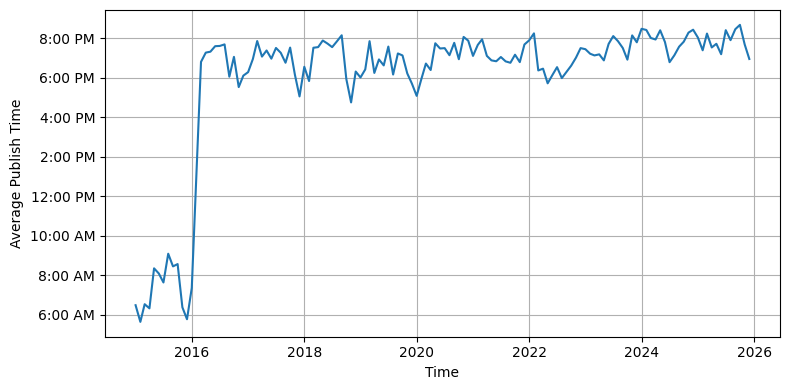

In [ ]:
# Plot a line graph of mean publishing times at a monthly frequency
plot_mean_publish_times(mean_publish_times["monthly_mean_hour"])

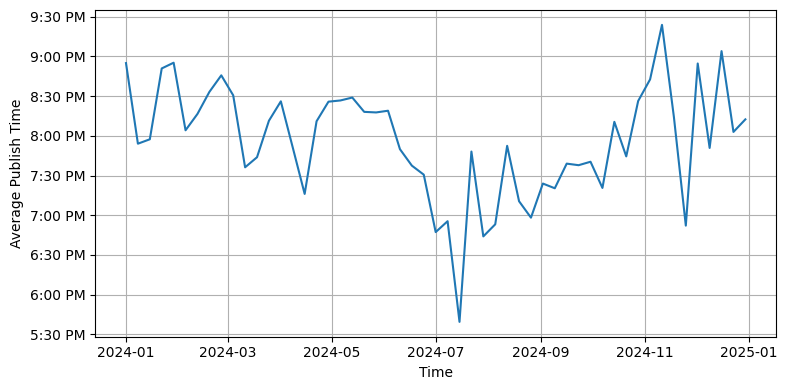

In [ ]:
# Plot a line graph of mean publishing times at a weekly frequency for 2024
plot_mean_publish_times(
    filter_mean_publish_dates(
        mean_publish_times["weekly_mean_hour"],
        start="2024-01-01",
        end="2024-12-31"))

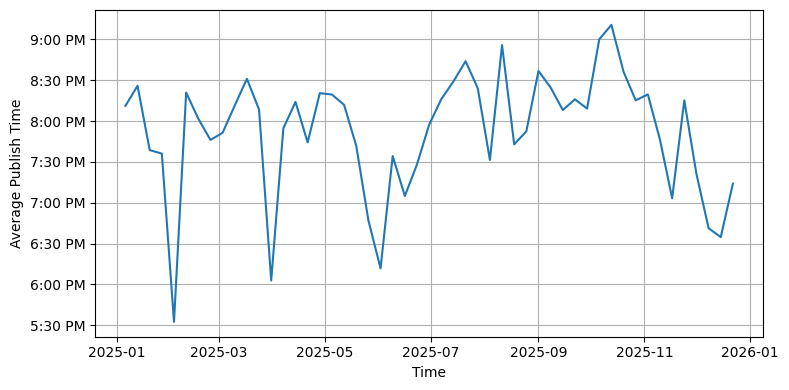

In [ ]:
# Plot a line graph of mean publishing times at a weekly frequency for 2025
plot_mean_publish_times(
    filter_mean_publish_dates(
        mean_publish_times["weekly_mean_hour"],
        start="2025-01-01",
        end="2025-12-31"))

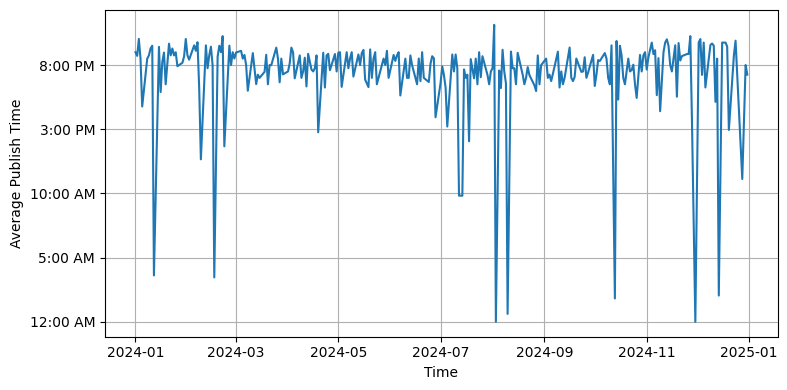

In [ ]:
# Plot a line graph of mean publishing times at a daily frequency for 2024
plot_mean_publish_times(
    filter_mean_publish_dates(
        mean_publish_times["daily_mean_hour"],
        start="2024-01-01",
        end="2024-12-31"))

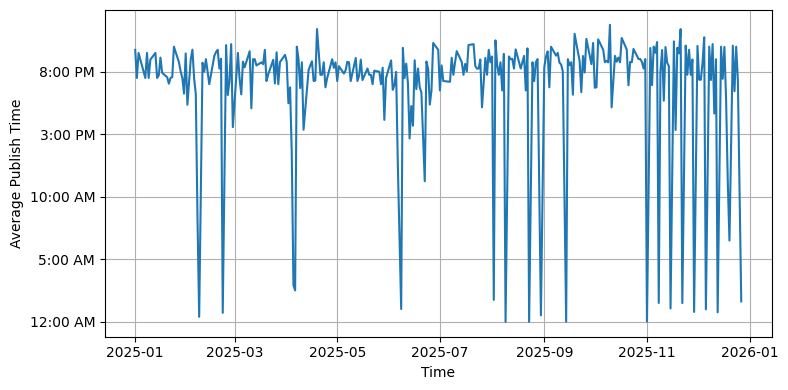

In [ ]:
# Plot a line graph of mean publishing times at a daily frequency for 2025
plot_mean_publish_times(
    filter_mean_publish_dates(
        mean_publish_times["daily_mean_hour"],
        start="2025-01-01",
        end="2025-12-31"))